<a href="https://colab.research.google.com/github/AttilaBS/mvp-machine-learning/blob/main/MVP_Machine_Learning_Attila_Barcellos_Sipos.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## MVP - Predição de Doenças Coronárias com Base em Hábitos pré-existentes e outras variáveis.

In [11]:
# configuração para não exibir os warnings
import warnings
warnings.filterwarnings("ignore")

# Imports necessários
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
import pickle

## Carga do Dataset

In [12]:
# Informa a URL de importação do dataset
url = "https://raw.githubusercontent.com/AttilaBS/mvp-machine-learning/main/dataset/framingham.csv"

# Lê o arquivo
heart_dataset = pd.read_csv(url, delimiter=',')

### Renomeando colunas para melhor visualização

In [13]:
heart_dataset.rename(columns={'male':'sexo_masculino','age':'idade','education':'educação','currentSmoker':'fumante','cigsPerDay':'cigarros_dia','BPMeds':'medicamento_pressão','prevalentStroke':'enfartou','prevalentHyp':'hipertensão','totChol':'nível_colesterol','sysBP':'sístole','diaBP':'diástole','BMI':'IMC','heartRate':'batimentos','glucose':'glicose','TenYearCHD':'risco'},inplace=True)

# Mostra as primeiras linhas do dataset
heart_dataset.head(10)

,sexo_masculino,idade,educação,fumante,cigarros_dia,medicamento_pressão,enfartou,hipertensão,diabetes,nível_colesterol,sístole,diástole,IMC,batimentos,glicose,risco
0,1,39,4.0,0,0.0,0.0,0,0,0,195.0,106.0,70.0,26.97,80.0,77.0,0
1,0,46,2.0,0,0.0,0.0,0,0,0,250.0,121.0,81.0,28.73,95.0,76.0,0
2,1,48,1.0,1,20.0,0.0,0,0,0,245.0,127.5,80.0,25.34,75.0,70.0,0
3,0,61,3.0,1,30.0,0.0,0,1,0,225.0,150.0,95.0,28.58,65.0,103.0,1
4,0,46,3.0,1,23.0,0.0,0,0,0,285.0,130.0,84.0,23.10,85.0,85.0,0
5,0,43,2.0,0,0.0,0.0,0,1,0,228.0,180.0,110.0,30.30,77.0,99.0,0
6,0,63,1.0,0,0.0,0.0,0,0,0,205.0,138.0,71.0,33.11,60.0,85.0,1
7,0,45,2.0,1,20.0,0.0,0,0,0,313.0,100.0,71.0,21.68,79.0,78.0,0
8,1,52,1.0,0,0.0,0.0,0,1,0,260.0,141.5,89.0,26.36,76.0,79.0,0
9,1,43,1.0,1,30.0,0.0,0,1,0,225.0,162.0,107.0,23.61,93.0,88.0,0


### Explicação de algumas das variáveis existentes no dataset:

##### sexo_masculino: se a pessoa é do sexo masculino (1) ou feminino (0);
##### education: nível de educação, quanto maior, significa que a pessoa tem um nível mais elevado de educação formal;
##### medicamento_pressão: se a pessoa estava usando ou não medicamento para regulação da pressão sanguínea;
##### enfartou: se a pessoa teve ou não um ataque cardíaco antes;
##### diabetes: se a pessoa tinha ou não diabetes;
##### colesterol: nível total de colesterol;
##### sístole: pressão sanguínea sistólica;
##### diastole: pressão sanguínea diastólica;
##### IMC: índice de massa corporal;
##### risco: coluna de saída, risco de a pessoa ter doença cardíaca em 10 anos, sim (1) ou não (0).

### Verificar se o dataset possui valores faltando e contar o número de colunas

In [14]:
# somar as colunas com valores faltando
heart_dataset.isnull().sum()

sexo_masculino           0
idade                    0
educação               105
fumante                  0
cigarros_dia            29
medicamento_pressão     53
enfartou                 0
hipertensão              0
diabetes                 0
nível_colesterol        50
sístole                  0
diástole                 0
IMC                     19
batimentos               1
glicose                388
risco                    0
dtype: int64

### Contar as linhas com valores faltando e as somar

In [15]:
count = 0
for i in heart_dataset.isnull().sum(axis=1):
    if i > 0:
        count = count + 1
print(f'O número total de linhas com valores faltando é {count}.')
print(f'A porcentagem de linhas com valores faltando é {round((count/len(heart_dataset.index)) * 100)}% de todo o dataset.')

O número total de linhas com valores faltando é 582.
A porcentagem de linhas com valores faltando é 14% de todo o dataset.


### Em razão do número de linhas com valores faltando não ser significativo, iremos retirá-las e verificar novamente se sobraram valores faltando.

In [16]:
heart_dataset.dropna(axis=0,inplace=True)
heart_dataset.isnull().sum()

sexo_masculino         0
idade                  0
educação               0
fumante                0
cigarros_dia           0
medicamento_pressão    0
enfartou               0
hipertensão            0
diabetes               0
nível_colesterol       0
sístole                0
diástole               0
IMC                    0
batimentos             0
glicose                0
risco                  0
dtype: int64

## Separação em conjunto de treino e conjunto de teste com holdout

In [17]:
test_size = 0.25 # tamanho do conjunto de teste
seed = 7 # semente aleatória

# Separação em conjuntos de treino e teste
array = heart_dataset.values
X = array[:,0:15]
y = array[:,15]
X_train, X_test, y_train, y_test = train_test_split(X, y,
    test_size=test_size, shuffle=True, random_state=seed, stratify=y) # holdout com estratificação

# Parâmetros e partições da validação cruzada
scoring = 'accuracy'
num_particoes = 10
kfold = StratifiedKFold(n_splits=num_particoes, shuffle=True, random_state=seed) # validação cruzada com estratificação

## Modelagem e Inferência

### Criação e avaliação de modelos: linha base


KNN: 0.832656 (0.011600)
CART: 0.749152 (0.024281)
NB: 0.821356 (0.012630)
SVM: 0.848705 (0.002500)


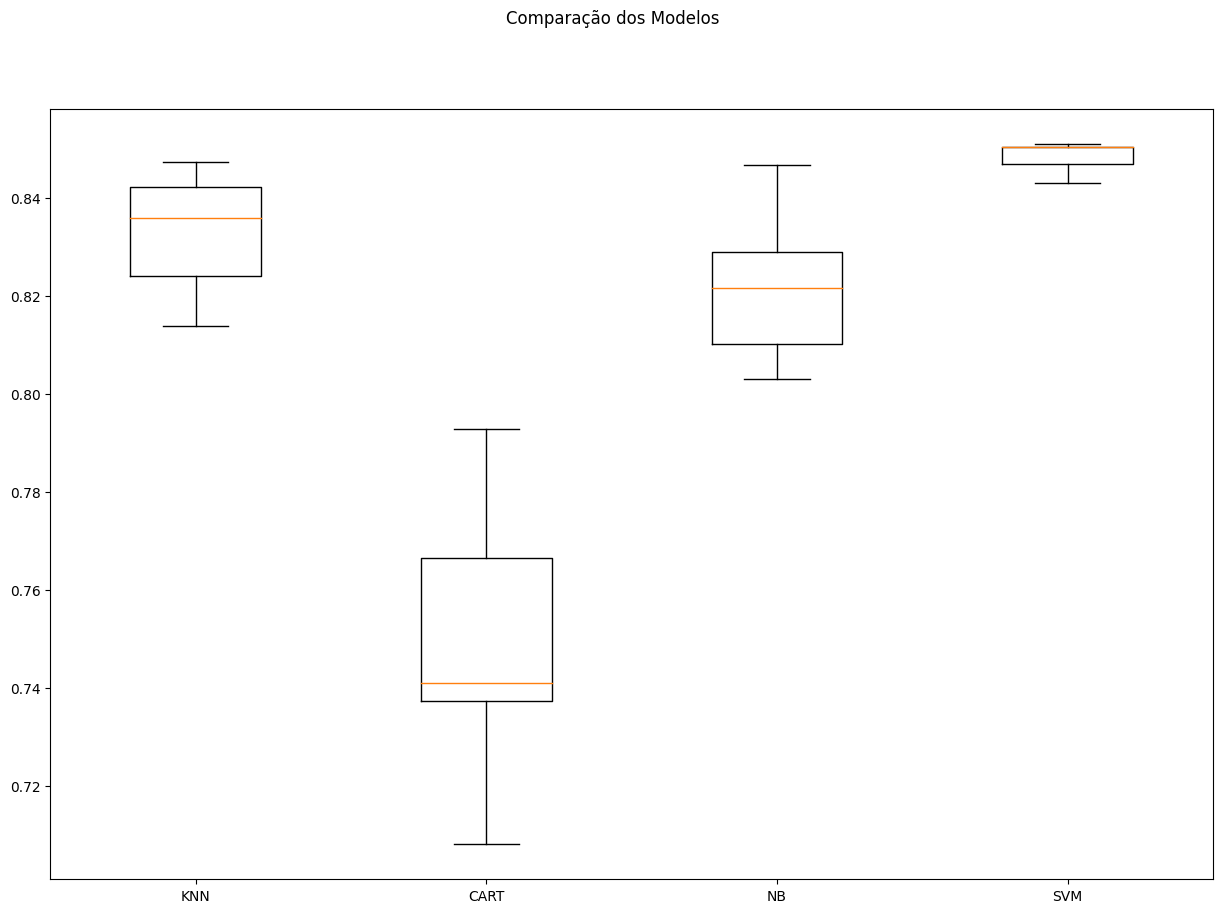

In [18]:
np.random.seed(7) # definindo uma semente global

# Lista que armazenará os modelos
models = []

# Criando os modelos e adicionando-os na lista de modelos
models.append(('KNN', KNeighborsClassifier()))
models.append(('CART', DecisionTreeClassifier()))
models.append(('NB', GaussianNB()))
models.append(('SVM', SVC()))

# Listas para armazenar os resultados
results = []
names = []

# Avaliação dos modelos
for name, model in models:
    cv_results = cross_val_score(model, X_train, y_train, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)

# Boxplot de comparação dos modelos
fig = plt.figure(figsize=(15,10))
fig.suptitle('Comparação dos Modelos')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

### Criação e avaliação de modelos: dados padronizados e normalizados

KNN-orig: 0.833 (0.012)
CART-orig: 0.749 (0.024)
NB-orig: 0.821 (0.013)
SVM-orig: 0.849 (0.003)
KNN-padr: 0.833 (0.010)
CART-padr: 0.748 (0.021)
NB-padr: 0.821 (0.013)
SVM-padr: 0.848 (0.005)
KNN-norm: 0.832 (0.011)
CART-norm: 0.752 (0.015)
NB-norm: 0.821 (0.013)
SVM-norm: 0.847 (0.002)


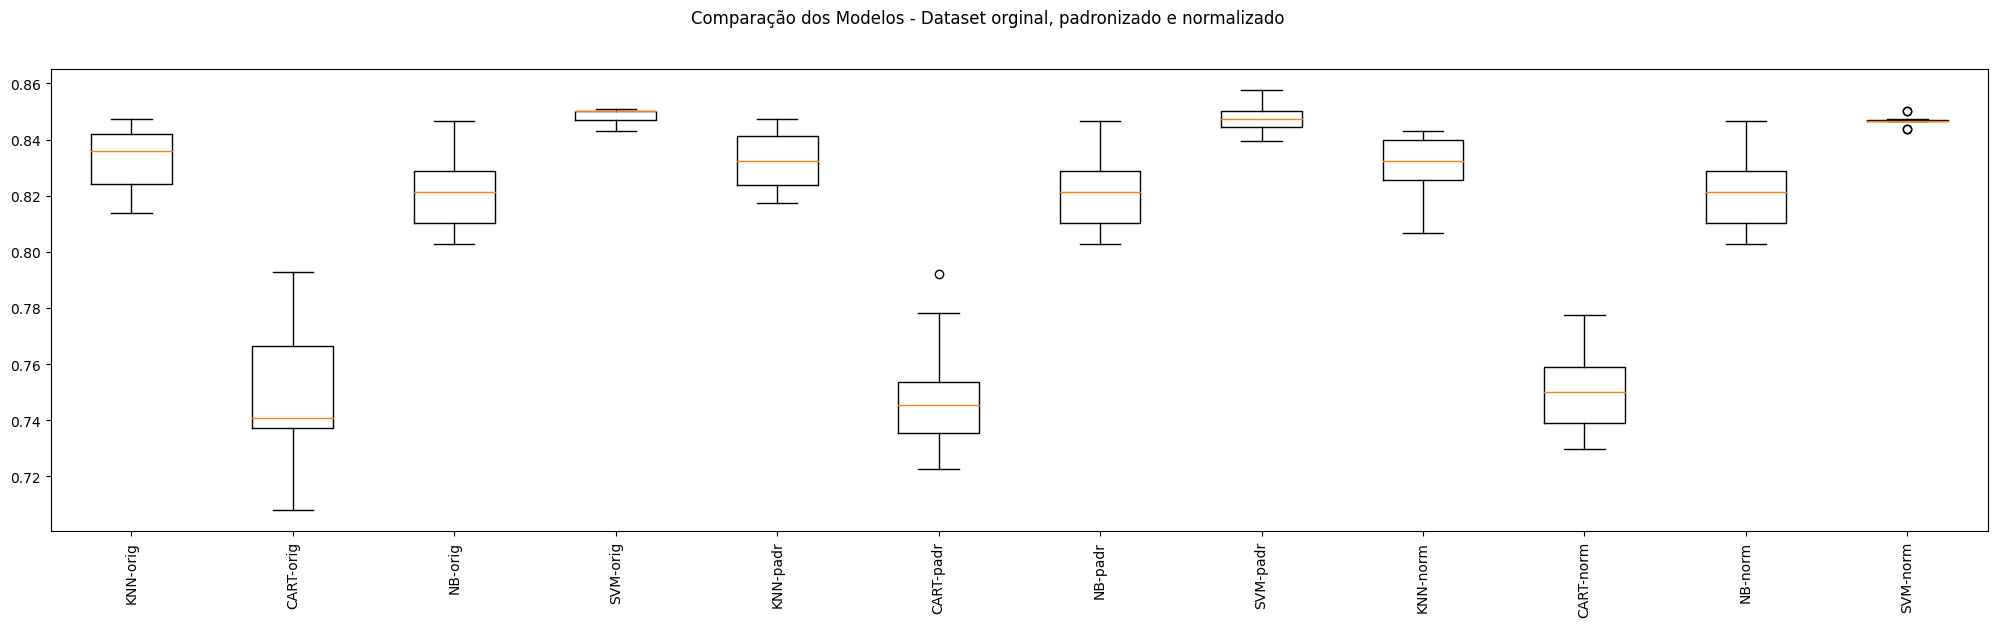

In [19]:
np.random.seed(7) # definindo uma semente global para este bloco

# Listas para armazenar os armazenar os pipelines e os resultados para todas as visões do dataset
pipelines = []
results = []
names = []


# Criando os elementos do pipeline

# Algoritmos que serão utilizados
knn = ('KNN', KNeighborsClassifier())
cart = ('CART', DecisionTreeClassifier())
naive_bayes = ('NB', GaussianNB())
svm = ('SVM', SVC())

# Transformações que serão utilizadas
standard_scaler = ('StandardScaler', StandardScaler())
min_max_scaler = ('MinMaxScaler', MinMaxScaler())


# Montando os pipelines

# Dataset original
pipelines.append(('KNN-orig', Pipeline([knn])))
pipelines.append(('CART-orig', Pipeline([cart])))
pipelines.append(('NB-orig', Pipeline([naive_bayes])))
pipelines.append(('SVM-orig', Pipeline([svm])))

# Dataset Padronizado
pipelines.append(('KNN-padr', Pipeline([standard_scaler, knn])))
pipelines.append(('CART-padr', Pipeline([standard_scaler, cart])))
pipelines.append(('NB-padr', Pipeline([standard_scaler, naive_bayes])))
pipelines.append(('SVM-padr', Pipeline([standard_scaler, svm])))

# Dataset Normalizado
pipelines.append(('KNN-norm', Pipeline([min_max_scaler, knn])))
pipelines.append(('CART-norm', Pipeline([min_max_scaler, cart])))
pipelines.append(('NB-norm', Pipeline([min_max_scaler, naive_bayes])))
pipelines.append(('SVM-norm', Pipeline([min_max_scaler, svm])))

# Executando os pipelines
for name, model in pipelines:
    cv_results = cross_val_score(model, X_train, y_train, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %.3f (%.3f)" % (name, cv_results.mean(), cv_results.std()) # formatando para 3 casas decimais
    print(msg)

# Boxplot de comparação dos modelos
fig = plt.figure(figsize=(25,6))
fig.suptitle('Comparação dos Modelos - Dataset orginal, padronizado e normalizado')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names, rotation=90)
plt.show()

### Otimização dos hiperparâmetros

In [20]:
# Tuning do KNN

np.random.seed(7) # definindo uma semente global para este bloco

pipelines = []

# Definindo os componentes do pipeline
knn = ('KNN', KNeighborsClassifier())
standard_scaler = ('StandardScaler', StandardScaler())
min_max_scaler = ('MinMaxScaler', MinMaxScaler())

pipelines.append(('knn-orig', Pipeline(steps=[knn])))
pipelines.append(('knn-padr', Pipeline(steps=[standard_scaler, knn])))
pipelines.append(('knn-norm', Pipeline(steps=[min_max_scaler, knn])))

param_grid = {
    'KNN__n_neighbors': [1,3,5,7,9,11,13,15,17,19,21],
    'KNN__metric': ["euclidean", "manhattan", "minkowski"],
}

# Prepara e executa o GridSearchCV
for name, model in pipelines:
    grid = GridSearchCV(estimator=model, param_grid=param_grid, scoring=scoring, cv=kfold)
    grid.fit(X_train, y_train)
    # imprime a melhor configuração
    print("Sem tratamento de missings: %s - Melhor: %f usando %s" % (name, grid.best_score_, grid.best_params_))

Sem tratamento de missings: knn-orig - Melhor: 0.850527 usando {'KNN__metric': 'manhattan', 'KNN__n_neighbors': 19}
Sem tratamento de missings: knn-padr - Melhor: 0.851253 usando {'KNN__metric': 'euclidean', 'KNN__n_neighbors': 19}
Sem tratamento de missings: knn-norm - Melhor: 0.849070 usando {'KNN__metric': 'manhattan', 'KNN__n_neighbors': 17}


## Finalização do Modelo

In [21]:
# Avaliação do modelo com o conjunto de testes

# Preparação do modelo
scaler = StandardScaler().fit(X_train) # ajuste do scaler com o conjunto de treino
rescaledX = scaler.transform(X_train) # aplicação da padronização no conjunto de treino
model = KNeighborsClassifier(metric='manhattan', n_neighbors=19)
model.fit(rescaledX, y_train)

# Estimativa da acurácia no conjunto de teste
rescaledTestX = scaler.transform(X_test) # aplicação da padronização no conjunto de teste
predictions = model.predict(rescaledTestX)
print(accuracy_score(y_test, predictions))

0.848087431693989


In [22]:
# Preparação do modelo com TODO o dataset
scaler = StandardScaler().fit(X) # ajuste do scaler com TODO o dataset
rescaledX = scaler.transform(X) # aplicação da padronização com TODO o dataset
model.fit(rescaledX, y)

KNeighborsClassifier(metric='manhattan', n_neighbors=19)

## Exportando o modelo treinado para um arquivo

In [23]:
pickle_out = open('modelo_treinado.pkl', 'wb')
pickle.dump(model, pickle_out)
pickle_out.close()

## Simulando a aplicação do modelo em dados não vistos

In [24]:
# Novos dados - não sabemos o resultado.
data = {'sexo_masculino':  [1, 0, 1],
        'idade': [19, 45, 60],
        'educação': [.10, 4.0, 2.0],
        'fumante': [0, 1, 0],
        'cigarros_dia': [0, 15, 0],
        'medicamento_pressão': [0, 1, 1],
        'enfartou': [1, 1, 0],
        'hipertensão': [0, 0, 1],
        'diabetes': [1, 1, 1],
        'nível_colesterol': [120, 99, 240],
        'sístole': [110.5, 133, 141.5],
        'diástole': [70, 85, 120],
        'IMC': [24.25, 30.4, 20.2],
        'batimentos': [70, 95, 73],
        'glicose': [113, 64, 215]
        }

attributes = ['sexo_masculino', 'idade', 'educação', 'fumante', 'cigarros_dia', 'medicamento_pressão', 'enfartou', 'hipertensão', 'diabetes', 'nível_colesterol', 'sístole', 'diástole', 'IMC', 'batimentos', 'glicose']
entrance = pd.DataFrame(data, columns=attributes)

entrance_array = entrance.values
X_entrance = entrance_array[:,0:15].astype(float)

# Padronização nos dados de entrada usando o scaler utilizado em X
rescaledEntranceX = scaler.transform(X_entrance)
print(rescaledEntranceX)

[[ 1.11975484 -3.56879382 -1.83891186 -0.97836413 -0.75716891 -0.17690125
  13.16018526 -0.67285977  5.99578977 -2.65011001 -0.99034187 -1.07888084
  -0.37706892 -0.47836235  1.30317603]
 [-0.89305263 -0.53171544  1.97520875  1.02211434  0.50122449  5.65287139
  13.16018526 -0.67285977  5.99578977 -3.12639064  0.02850239  0.17397768
   1.13582951  1.60846859 -0.74695631]
 [ 1.11975484  1.22044516  0.01924946 -0.97836413 -0.75716891  5.65287139
  -0.07598677  1.48619377  5.99578977  0.07149355  0.4133991   3.09731423
  -1.37336788 -0.22794264  5.57079844]]


In [25]:
# Predição de classes dos dados de entrada
exit = model.predict(rescaledEntranceX)
print(exit)

[0. 0. 1.]
